In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, TaskType, get_peft_model
from safetensors.torch import load_file
from dataclasses import dataclass, field
from typing import Optional, List, Dict, Any
from contextlib import contextmanager
import copy
import pandas as pd
import numpy as np
from tqdm import tqdm

# ==============================================================================
# 1. SETUP AND CLASS DEFINITIONS (FROM ORIGINAL SCRIPT)
# ==============================================================================

@dataclass
class ModelArguments:
    model_name_or_path: str = field(default="gpt2")
    lora_r: int = field(default=128)
    lora_alpha: int = field(default=32)
    lora_init: bool = field(default=True)

@dataclass
class TrainingArguments:
    bf16: bool = field(default=True)
    model_max_length: int = field(default=512)
    inf_latent_iterations: int = field(default=6)
    use_prj: bool = field(default=True)
    prj_dim: int = field(default=768)
    prj_no_ln: bool = field(default=False)
    prj_dropout: float = field(default=0.0)
    use_lora: bool = field(default=True)

class CODI(torch.nn.Module):
    """The main model class that wraps the base language model."""
    def __init__(self, model_args, training_args, lora_config):
        super().__init__()
        self.model_args = model_args
        self.training_args = training_args
        self.model_name = model_args.model_name_or_path
        self.codi = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            torch_dtype=(torch.bfloat16 if training_args.bf16 else torch.float32),
        )
        ori_vocab_size = self.codi.config.vocab_size
        self.pad_token_id = ori_vocab_size
        self.bot_id = ori_vocab_size + 1
        self.eot_id = ori_vocab_size + 2
        self.codi.resize_token_embeddings(ori_vocab_size + 3)
        self.dim = self.codi.config.hidden_size
        if training_args.use_lora:
            self.codi = get_peft_model(self.codi, lora_config)
        if training_args.use_prj:
            self.prj = nn.Sequential(
                nn.Dropout(training_args.prj_dropout),
                nn.Linear(self.dim, training_args.prj_dim),
                nn.GELU(),
                nn.Linear(training_args.prj_dim, self.dim),
            )
            if not self.training_args.prj_no_ln:
                self.prj.add_module("ln", nn.LayerNorm(self.dim))

    def get_embd(self, model, model_name):
        """Helper function to get the embedding layer."""
        return model.get_input_embeddings()


# ==============================================================================
# 2. PATCHING EXPERIMENT FUNCTION DEFINITIONS
# ==============================================================================

@contextmanager
def apply_forward_hook(module, hook_fn):
    """Context manager to apply a forward hook and automatically remove it."""
    handle = module.register_forward_hook(hook_fn)
    try:
        yield
    finally:
        handle.remove()

def batch_iterator(dataset: List[Dict], batch_size: int):
    """Generator to yield batches of data from the loaded dataset."""
    for i in range(0, len(dataset), batch_size):
        yield dataset[i:i + batch_size]

def _get_logits_from_kv_cache(
    model: CODI,
    tokenizer: AutoTokenizer,
    starting_kv_cache: tuple,
    batch_size: int,
    device: torch.device,
    max_new_tokens: int = 256
) -> (List[torch.Tensor], List[List[int]]):
    """
    Performs autoregressive generation from a given KV cache.
    
    Returns:
        - A list of tensors, each containing the logits for one sequence.
        - A list of lists, each containing the generated token IDs for one sequence.
    """
    past_key_values = copy.deepcopy(starting_kv_cache)
    eot_token_id = torch.full((batch_size, 1), model.eot_id, dtype=torch.long, device=device)
    next_input_embeds = model.get_embd(model.codi, model.model_name)(eot_token_id)
    
    all_logits_batch = [[] for _ in range(batch_size)]
    generated_tokens_batch = [[] for _ in range(batch_size)]
    unfinished_sequences = torch.ones(batch_size, dtype=torch.long, device=device)

    with torch.no_grad():
        for _ in range(max_new_tokens):
            out = model.codi(inputs_embeds=next_input_embeds, use_cache=True, past_key_values=past_key_values)
            past_key_values = out.past_key_values
            current_logits = out.logits[:, -1, :]
            next_token_ids = torch.argmax(current_logits, dim=-1)
            
            finished_now = (next_token_ids == tokenizer.eos_token_id)
            
            for i in range(batch_size):
                if unfinished_sequences[i]:
                    all_logits_batch[i].append(current_logits[i])
                    generated_tokens_batch[i].append(next_token_ids[i].item())

            unfinished_sequences.masked_fill_(finished_now.bool(), 0)
            if unfinished_sequences.max() == 0:
                break
            
            next_input_embeds = model.get_embd(model.codi, model.model_name)(next_token_ids.unsqueeze(-1))
            
    final_logits = [torch.stack(logits) if logits else torch.empty(0, device=device) for logits in all_logits_batch]
    return final_logits, generated_tokens_batch

def _run_inference_and_cache_for_patching(
    model: CODI,
    tokenizer: AutoTokenizer,
    training_args: TrainingArguments,
    batch_questions: List[str],
    device: torch.device,
    patch_thought_idx: Optional[int] = None,
    patch_layer_idx: Optional[int] = None,
    activation_to_patch: Optional[torch.Tensor] = None
) -> (List[torch.Tensor], List[List[int]], Dict[int, Dict[int, torch.Tensor]]):
    """
    A unified function to run inference, now returning generated tokens alongside logits.
    """
    model.eval()
    batch_size = len(batch_questions)
    activation_cache = {t: {} for t in range(1, training_args.inf_latent_iterations + 1)}
    thought_counter = [0] 
    
    def patch_activation_hook(module, args, output):
        if thought_counter[0] == patch_thought_idx:
            return (activation_to_patch,) + output[1:]
        return output

    hook_context = contextmanager(lambda: (yield))()
    if patch_thought_idx is not None and patch_layer_idx is not None and activation_to_patch is not None:
        target_layer = model.codi.transformer.h[patch_layer_idx]
        hook_context = apply_forward_hook(target_layer, patch_activation_hook)

    with torch.no_grad(), hook_context:
        inputs = tokenizer(batch_questions, return_tensors="pt", padding=True, truncation=True).to(device)
        bot_tensor = torch.full((batch_size, 1), model.bot_id, dtype=torch.long, device=device)
        input_ids = torch.cat((inputs["input_ids"], bot_tensor), dim=1)
        attention_mask = torch.cat((inputs["attention_mask"], torch.ones_like(bot_tensor)), dim=1)
        
        outputs = model.codi(input_ids=input_ids, attention_mask=attention_mask, use_cache=True, output_hidden_states=True)
        past_key_values = outputs.past_key_values
        latent_embd = outputs.hidden_states[-1][:, -1, :].unsqueeze(1)
        if training_args.use_prj: latent_embd = model.prj(latent_embd)
        
        for i in range(1, training_args.inf_latent_iterations + 1):
            thought_counter[0] = i
            outputs = model.codi(inputs_embeds=latent_embd, use_cache=True, output_hidden_states=True, past_key_values=past_key_values)
            
            if patch_thought_idx is None:
                for layer_idx, layer_hidden_state in enumerate(outputs.hidden_states):
                    activation_cache[i][layer_idx] = layer_hidden_state.clone().detach()

            past_key_values = outputs.past_key_values
            latent_embd = outputs.hidden_states[-1][:, -1, :].unsqueeze(1)
            if training_args.use_prj: latent_embd = model.prj(latent_embd)

    final_logits_batch, generated_tokens_batch = _get_logits_from_kv_cache(model, tokenizer, past_key_values, batch_size, device)
    
    return final_logits_batch, generated_tokens_batch, activation_cache

def calculate_log_prob(
    logits: torch.Tensor, 
    target_token_ids: List[int], 
    start_index: Optional[int]
) -> float:
    """
    Calculates the average log probability of target tokens starting from a specific index.
    """
    if start_index is None or not target_token_ids:
        return np.nan
        
    # Determine how many tokens we can actually check
    num_tokens_available = logits.shape[0] - start_index
    if num_tokens_available <= 0:
        return np.nan # Generation was too short, didn't even reach the start index
        
    num_tokens_to_check = min(len(target_token_ids), num_tokens_available)
    
    # Slice the relevant parts
    logits_slice = logits[start_index : start_index + num_tokens_to_check]
    target_ids_slice = target_token_ids[:num_tokens_to_check]
    
    log_probs = F.log_softmax(logits_slice, dim=-1)
    
    target_log_probs = log_probs.gather(
        dim=-1, 
        index=torch.tensor(target_ids_slice, device=logits.device).unsqueeze(-1)
    ).squeeze(-1)
    
    return torch.mean(target_log_probs).item()

def find_answer_start_index(generated_token_ids: List[int], tokenizer: AutoTokenizer) -> Optional[int]:
    """
    Finds the index of the first token that contains the start of the answer.
    This is done by detecting when the ': ' prefix first appears during iterative decoding.
    This approach is robust to tokenization boundaries where the prefix and answer
    are part of the same token.
    """
    if not generated_token_ids:
        return None
    
    answer_prefix = ": "
    previous_decoded = ""
    
    # Iterate through the tokens, decoding one more token at each step
    for i in range(1, len(generated_token_ids) + 1):
        # Decode the current slice of tokens, skipping special tokens for clean comparison
        current_decoded = tokenizer.decode(generated_token_ids[:i], skip_special_tokens=True)
        
        # Check if the prefix has just appeared in this new, longer string
        # while it was not present in the shorter, previous string.
        if answer_prefix in current_decoded and answer_prefix not in previous_decoded:
            # The token at index (i-1) is the one that completed the prefix.
            # This is the first token that could possibly contain the answer.
            # We return its index as the start of our measurement.
            return i - 1
        
        previous_decoded = current_decoded
            
    # If the loop completes, the prefix was never found.
    return None

def run_patching_experiment(
    model: CODI,
    tokenizer: AutoTokenizer,
    training_args: TrainingArguments,
    dataset_path: str,
    batch_size: int,
    output_csv_path: str,
    device: torch.device
):
    """
    Main orchestrator for the causal tracing experiment.
    
    MODIFIED BEHAVIOR: This version no longer uses ground-truth answers from the CSV.
    Instead, it dynamically determines the "correct" answer tokens based on the model's
    own output during the unpatched clean and perturbed runs.
    The input CSV only needs 'index', 'original_question', 'perturbed_question'.
    """
    try:
        # The CSV no longer needs answer columns.
        dataset = pd.read_csv(dataset_path).to_dict('records')
    except FileNotFoundError:
        print(f"Error: Dataset not found at {dataset_path}")
        return

    results_data = []
    num_layers = len(model.codi.transformer.h)
    print(f"Starting experiment with {num_layers} layers.")
    
    for batch_data in tqdm(batch_iterator(dataset, batch_size), total=-(-len(dataset)//batch_size), desc="Processing Batches"):
        
        original_qs = [item['original_question'] for item in batch_data]
        perturbed_qs = [item['perturbed_question'] for item in batch_data]
        pair_ids = [item['index'] for item in batch_data]
        
        # --- Step 1: Run on PERTURBED questions to get cache and DEFINE perturbed answer tokens ---
        perturbed_logits, perturbed_tokens, activation_cache = _run_inference_and_cache_for_patching(
            model, tokenizer, training_args, perturbed_qs, device
        )
        
        # DYNAMICALLY DEFINE THE "PERTURBED ANSWER" TARGETS
        perturbed_a_tokens = []
        for i in range(len(batch_data)):
            start_idx = find_answer_start_index(perturbed_tokens[i], tokenizer)
            if start_idx is not None:
                # Slice from start index to the end
                ans_tokens = perturbed_tokens[i][start_idx:]
                # Exclude the EOS token if it's the last one
                if ans_tokens and ans_tokens[-1] == tokenizer.eos_token_id:
                    ans_tokens = ans_tokens[:-1]
                perturbed_a_tokens.append(ans_tokens)
            else:
                perturbed_a_tokens.append([]) # Append empty list if no answer found

        # --- Step 2: Run on ORIGINAL questions to get baseline and DEFINE original answer tokens ---
        clean_logits, clean_tokens, _ = _run_inference_and_cache_for_patching(
            model, tokenizer, training_args, original_qs, device
        )

        # DYNAMICALLY DEFINE THE "ORIGINAL ANSWER" TARGETS
        original_a_tokens = []
        for i in range(len(batch_data)):
            start_idx = find_answer_start_index(clean_tokens[i], tokenizer)
            if start_idx is not None:
                ans_tokens = clean_tokens[i][start_idx:]
                if ans_tokens and ans_tokens[-1] == tokenizer.eos_token_id:
                    ans_tokens = ans_tokens[:-1]
                original_a_tokens.append(ans_tokens)
            else:
                original_a_tokens.append([])

        # --- Store baseline results using the dynamically generated targets ---
        for i in range(len(batch_data)):
            clean_start_idx = find_answer_start_index(clean_tokens[i], tokenizer)
            perturbed_start_idx = find_answer_start_index(perturbed_tokens[i], tokenizer)
            
            results_data.append({
                "pair_id": pair_ids[i], "run_type": "clean", "thought_idx": -1, "layer_idx": -1,
                "log_prob_original_answer": calculate_log_prob(clean_logits[i], original_a_tokens[i], clean_start_idx),
                "log_prob_perturbed_answer": calculate_log_prob(clean_logits[i], perturbed_a_tokens[i], clean_start_idx)
            })
            results_data.append({
                "pair_id": pair_ids[i], "run_type": "perturbed", "thought_idx": -1, "layer_idx": -1,
                "log_prob_original_answer": calculate_log_prob(perturbed_logits[i], original_a_tokens[i], perturbed_start_idx),
                "log_prob_perturbed_answer": calculate_log_prob(perturbed_logits[i], perturbed_a_tokens[i], perturbed_start_idx)
            })
            
        # --- Step 3: Iterate through all patch points and run patched inference ---
        for thought_idx in range(1, training_args.inf_latent_iterations + 1):
            for layer_idx in range(num_layers):
                
                activations_to_patch_list = [activation_cache[thought_idx][layer_idx][i:i+1] for i in range(len(batch_data))]
                batched_activation = torch.cat(activations_to_patch_list, dim=0)

                patched_logits, patched_tokens, _ = _run_inference_and_cache_for_patching(
                    model, tokenizer, training_args, original_qs, device,
                    patch_thought_idx=thought_idx, patch_layer_idx=layer_idx, activation_to_patch=batched_activation
                )
                
                for i in range(len(batch_data)):
                    patched_start_idx = find_answer_start_index(patched_tokens[i], tokenizer)
                    results_data.append({
                        "pair_id": pair_ids[i], "run_type": "patched",
                        "thought_idx": thought_idx, "layer_idx": layer_idx,
                        "log_prob_original_answer": calculate_log_prob(patched_logits[i], original_a_tokens[i], patched_start_idx),
                        "log_prob_perturbed_answer": calculate_log_prob(patched_logits[i], perturbed_a_tokens[i], patched_start_idx)
                    })

    print(f"Experiment finished. Saving {len(results_data)} results to {output_csv_path}...")
    pd.DataFrame(results_data).to_csv(output_csv_path, index=False)
    print("Save complete.")

def refactor_results_to_wide_format(long_csv_path: str, final_csv_path: str, dataset_path: str):
    """
    Reads the long-format CSV, pivots it to a wide format, and merges
    with original question data for context. Answer columns are no longer used.
    """
    print(f"Reading long-format data from {long_csv_path}...")
    try:
        long_df = pd.read_csv(long_csv_path)
        # Only need questions for context, not answers.
        dataset_df = pd.read_csv(dataset_path).rename(columns={'index': 'pair_id'})
        context_cols = ['pair_id', 'original_question', 'perturbed_question']
        dataset_df = dataset_df[context_cols]
    except FileNotFoundError as e:
        print(f"Error: Could not find a required file. {e}")
        return
    except KeyError:
        print(f"Warning: The dataset at {dataset_path} is missing one of the required context columns: {context_cols}")
        # Create a dummy dataframe with just pair_ids from the results
        dataset_df = pd.DataFrame({'pair_id': long_df['pair_id'].unique()})


    # Separate baseline and patched results
    baseline_df = long_df[long_df['run_type'].isin(['clean', 'perturbed'])]
    patched_df = long_df[long_df['run_type'] == 'patched']

    # Pivot baseline results
    baseline_wide = baseline_df.pivot_table(
        index='pair_id',
        columns='run_type',
        values=['log_prob_original_answer', 'log_prob_perturbed_answer']
    ).reset_index()
    # Flatten multi-level column names
    baseline_wide.columns = [f'{val}_{run}' for val, run in baseline_wide.columns]
    baseline_wide = baseline_wide.rename(columns={'pair_id_': 'pair_id'})

    # Aggregate patched results into lists
    patched_df = patched_df.sort_values(by=['pair_id', 'thought_idx', 'layer_idx'])
    patched_agg = patched_df.groupby('pair_id').agg({
        'log_prob_original_answer': list,
        'log_prob_perturbed_answer': list
    }).reset_index()
    patched_agg = patched_agg.rename(columns={
        'log_prob_original_answer': 'patched_log_prob_original_list',
        'log_prob_perturbed_answer': 'patched_log_prob_perturbed_list'
    })

    # Merge all data together
    final_df = pd.merge(dataset_df, baseline_wide, on='pair_id', how='left')
    final_df = pd.merge(final_df, patched_agg, on='pair_id', how='left')

    print(f"Saving final wide-format results to {final_csv_path}...")
    final_df.to_csv(final_csv_path, index=False)
    print("Final CSV saved successfully.")
print("Defs Complete!")

Defs Complete!


In [2]:
# 2. MODEL AND TOKENIZER LOADING

# --- Configuration ---
# Set the device to CUDA if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the directory where your fine-tuned model checkpoint is stored.
# This should contain a 'model.safetensors' or 'codi.bin' file.
ckpt_dir = "./gpt" 

# --- Initialization ---
print("Initializing arguments and LoRA config...")
model_args = ModelArguments(model_name_or_path="gpt2")
training_args = TrainingArguments() # Uses default values from the class definition

# LoRA config must match the one used during fine-tuning.
# For GPT-2, the target modules are typically 'c_attn', 'c_proj', and 'c_fc'.
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, 
    r=model_args.lora_r, 
    lora_alpha=model_args.lora_alpha,
    lora_dropout=0.1, 
    target_modules=["c_attn", "c_proj", 'c_fc'], 
    init_lora_weights=True
)

# --- Model Loading ---
print("Initializing the CODI model architecture...")
# This creates the model with randomly initialized weights.
# We will load the trained weights in the next step.
model = CODI(model_args, training_args, lora_config)

print(f"Loading model checkpoint from directory: {ckpt_dir}...")
try:
    # Prefer the safe and fast safetensors format
    state_dict_path = os.path.join(ckpt_dir, "model.safetensors")
    state_dict = load_file(state_dict_path)
    print(f"Successfully loaded state dict from {state_dict_path}")
except FileNotFoundError:
    # Fallback to the standard PyTorch binary format
    state_dict_path = os.path.join(ckpt_dir, "codi.bin")
    state_dict = torch.load(state_dict_path, map_location=device)
    print(f"Successfully loaded state dict from {state_dict_path}")

# Load the trained weights into the model architecture.
# `strict=False` is used to ignore keys that might not match perfectly (e.g., optimizer state).
model.load_state_dict(state_dict, strict=False)
model.codi.tie_weights() # Important step after resizing token embeddings
print("Checkpoint weights loaded successfully.")

# --- Tokenizer Loading ---
print("Initializing tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(
    model_args.model_name_or_path, 
    padding_side="left", # Crucial for batched generation with causal LMs
    use_fast=False
)

# GPT-2 does not have a default pad token. We must add one and ensure
# its ID matches the one used by the model for consistency.
if tokenizer.pad_token_id is None:
    print("Tokenizer does not have a pad token. Adding '[PAD]'.")
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    # This ensures the tokenizer's pad_token_id is the same as the model's
    tokenizer.pad_token_id = model.pad_token_id
    print(f"Tokenizer pad token ID set to: {tokenizer.pad_token_id}")

# --- Final Preparation ---
# Move the model to the GPU and set its precision to bfloat16 for efficiency.
# .eval() puts the model in inference mode (disables dropout, etc.).
model.to(device).to(torch.bfloat16).eval()
print("\nModel and tokenizer are fully loaded and ready for inference.")

Using device: cuda
Initializing arguments and LoRA config...
Initializing the CODI model architecture...


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1768: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Loading model checkpoint from directory: ./gpt...
Successfully loaded state dict from ./gpt/codi.bin
Checkpoint weights loaded successfully.
Initializing tokenizer...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenizer does not have a pad token. Adding '[PAD]'.
Tokenizer pad token ID set to: 50257

Model and tokenizer are fully loaded and ready for inference.


In [7]:
# ==============================================================================
# 3. RUN EXPERIMENT AND SAVE RESULTS
# ==============================================================================

# --- Experiment Configuration ---

# Path to your input CSV file.
# This file must contain the columns: 'index', 'original_question', 'original_answer',
# 'perturbed_question', and 'perturbed_answer'.
DATASET_CSV_PATH = "./data/perturbed_correct.csv"

# The batch size for inference. Adjust based on your GPU's VRAM.
# A smaller batch size uses less memory but may be slower.
BATCH_SIZE = 110

# Define output file paths.
# The 'long_format' file is a temporary file containing every single data point.
# The 'final_wide_format' file is the aggregated, user-friendly output.
LONG_FORMAT_OUTPUT_PATH = "./data/gpt_patching_results_long.csv"
FINAL_WIDE_FORMAT_OUTPUT_PATH = "./data/gpt_patching_results_final.csv"

# # --- Execute Experiment ---

# print("Starting the patching experiment...")
# print(f"Reading data from: {DATASET_CSV_PATH}")
# print(f"Using batch size: {BATCH_SIZE}")

# # This is the main function call that runs the entire causal tracing experiment.
# # It will iterate through all batches, thoughts, and layers, saving the raw
# # results to the long-format CSV file.
# run_patching_experiment(
#     model=model,
#     tokenizer=tokenizer,
#     training_args=training_args,
#     dataset_path=DATASET_CSV_PATH,
#     batch_size=BATCH_SIZE,
#     output_csv_path=LONG_FORMAT_OUTPUT_PATH,
#     device=device
# )

# print("\nExperiment data collection is complete.")
# print("-" * 50)

# --- Refactor Results ---

print("Refactoring the results from long to wide format...")

# This function takes the detailed temporary file and pivots it into the
# final, aggregated format that is easier to analyze and plot.
refactor_results_to_wide_format(
    long_csv_path=LONG_FORMAT_OUTPUT_PATH,
    final_csv_path=FINAL_WIDE_FORMAT_OUTPUT_PATH,
    dataset_path=DATASET_CSV_PATH
)

print("\nAll steps completed successfully!")
print(f"Final results have been saved to: {FINAL_WIDE_FORMAT_OUTPUT_PATH}")

Refactoring the results from long to wide format...
Reading long-format data from ./data/gpt_patching_results_long.csv...
Saving final wide-format results to ./data/gpt_patching_results_final.csv...
Final CSV saved successfully.

All steps completed successfully!
Final results have been saved to: ./data/gpt_patching_results_final.csv


Data loaded and preprocessed successfully.

--- Generating heatmap for a single question (ID=1) ---

--- Generating heatmap for a group of questions (IDs 1, 2, 3) ---


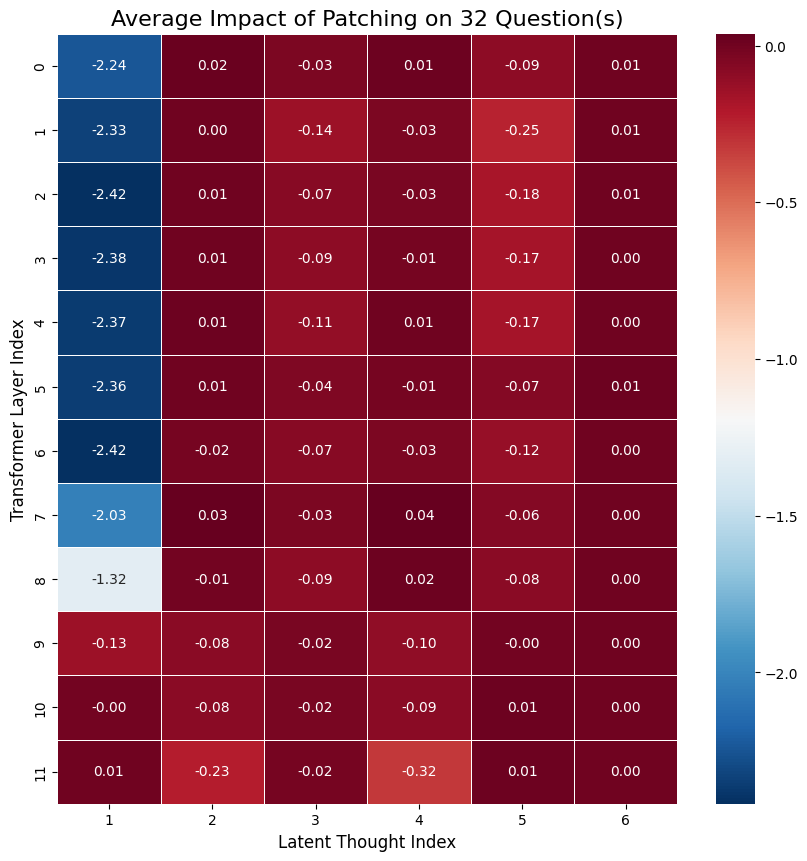


--- Generating heatmap for ALL questions in the dataset ---


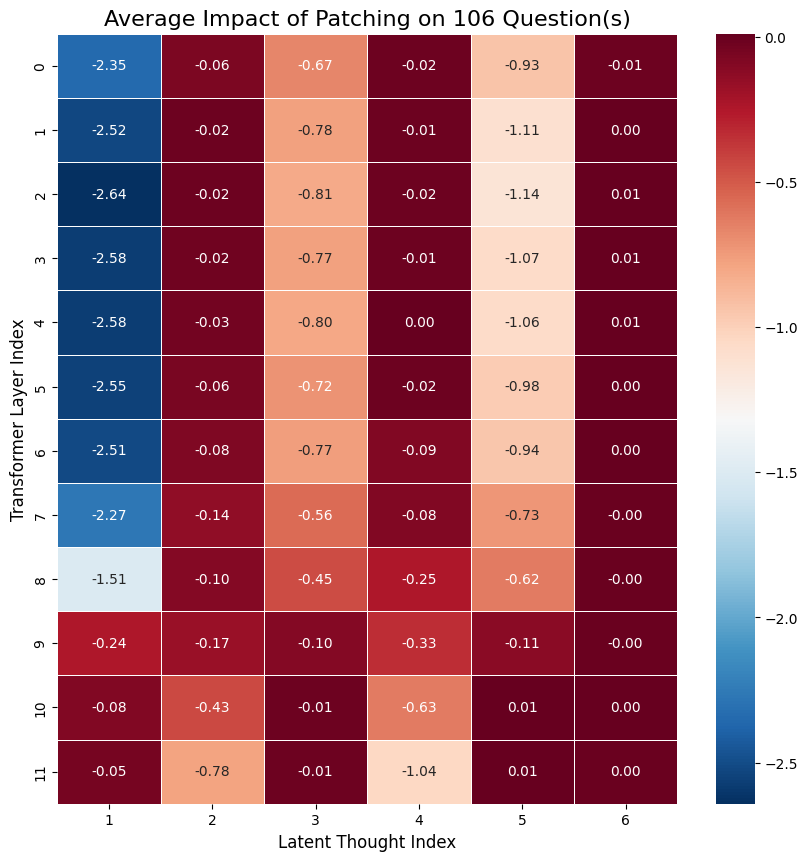

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast # Used for safely parsing string representations of lists

# --- Configuration ---
# IMPORTANT: You must set these values to match your experiment's parameters.

# The path to your final wide-format results file.
FILE_PATH = "./data/gpt_patching_results_final.csv"

# The number of layers in your GPT-2 model (e.g., standard gpt2 has 12).
NUM_LAYERS = 12

# The number of latent thoughts used in the experiment.
NUM_THOUGHTS = 6

def load_and_preprocess_data(file_path: str) -> pd.DataFrame:
    """
    Loads the wide-format CSV and preprocesses it for analysis.
    Specifically, it converts the string representation of lists back into
    actual Python lists of floats.
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return None

    # The 'patched_log_prob_original_list' column is a string.
    # We use ast.literal_eval to safely convert it into a Python list.
    def parse_list_string(s):
        try:
            return ast.literal_eval(s)
        except (ValueError, SyntaxError, TypeError):
            # Return an empty list if the string is malformed or NaN
            return []

    df['parsed_list'] = df['patched_log_prob_original_list'].apply(parse_list_string)
    print("Data loaded and preprocessed successfully.")
    return df


def generate_average_heatmap(df: pd.DataFrame, question_indices: list[int]):
    """
    Generates and displays an average heatmap for a given list of question indices.

    MODIFIED: This version plots Layers on the Y-axis and Thoughts on the X-axis.

    The heatmap visualizes the impact of patching at each thought/layer.
    Impact is calculated as: (log_prob_original_answer_patched - log_prob_original_answer_clean)
    A large negative value (blue) indicates a critical computation site.

    Args:
        df (pd.DataFrame): The preprocessed DataFrame containing experiment results.
        question_indices (list[int]): A list of 'pair_id's to average over.
    """
    if df is None or df.empty:
        print("DataFrame is empty or not loaded. Cannot generate heatmap.")
        return

    # 1. Filter the DataFrame to only include the questions we want to analyze.
    filtered_df = df[df['pair_id'].isin(question_indices)]

    if filtered_df.empty:
        print(f"Warning: No data found for the provided question indices: {question_indices}")
        return

    # 2. Calculate the "impact score" for each question.
    impact_scores = filtered_df.apply(
        lambda row: np.array(row['parsed_list']) - row['log_prob_original_answer_clean'],
        axis=1
    )
    
    impact_scores = [score for score in impact_scores if score.size > 0]
    
    if not impact_scores:
        print("No valid impact scores could be calculated for the selected indices.")
        return

    # 3. Average the impact scores element-wise across all selected questions.
    average_impact = np.mean(impact_scores, axis=0)

    # 4. Reshape the 1D array into a 2D matrix (still Thoughts x Layers initially).
    try:
        heatmap_data = average_impact.reshape((NUM_THOUGHTS, NUM_LAYERS))
    except ValueError:
        print(f"Error: Cannot reshape data. Expected {NUM_THOUGHTS * NUM_LAYERS} data points, but found {len(average_impact)}.")
        print("Please ensure NUM_LAYERS and NUM_THOUGHTS in your configuration match the experiment.")
        return

    # --- KEY CHANGE: Transpose the matrix to swap axes ---
    heatmap_data_transposed = heatmap_data.T

    # 5. Plot the transposed heatmap.
    plt.figure(figsize=(10, 10))
    
    ax = sns.heatmap(
        heatmap_data_transposed, # Use the transposed data
        annot=True,
        fmt=".2f",
        cmap='RdBu_r',
        linewidths=.5,
        # --- KEY CHANGE: Swap the tick labels ---
        xticklabels=range(1, NUM_THOUGHTS + 1), # X-axis is now Thoughts
        yticklabels=range(NUM_LAYERS)           # Y-axis is now Layers
    )

    title_text = f'Average Impact of Patching on {len(filtered_df)} Question(s)'
    if len(question_indices) <= 3:
        title_text += f' (IDs: {question_indices})'
        
    ax.set_title(title_text, fontsize=16)
    # --- KEY CHANGE: Swap the axis labels ---
    ax.set_xlabel('Latent Thought Index', fontsize=12)
    ax.set_ylabel('Transformer Layer Index', fontsize=12)
    plt.show()

# Load the data once
results_df = load_and_preprocess_data(FILE_PATH)

if results_df is not None:
    # --- Example 1: Analyze a single, specific question ---
    print("\n--- Generating heatmap for a single question (ID=1) ---")
    # This shows the causal trace for one specific reasoning process.
    generate_average_heatmap(df=results_df, question_indices=[1])

    # --- Example 2: Analyze a small group of related questions ---
    print("\n--- Generating heatmap for a group of questions (IDs 1, 2, 3) ---")
    # This is useful if you have several questions of the same type (e.g., all addition).
    # It averages out noise and reveals the common reasoning pathway.
    # +, -
    # to_analyze = [13, 79, 161, 174, 179]
    # -, +
    # to_analyze = [67, 111, 125, 155]
    # *, +
    to_analyze = [28, 36, 52, 72, 82, 129, 142, 164]
    # *, *
    to_analyze += [2, 18, 41, 55, 58, 60, 70, 73, 93, 100, 124]
    # *, -
    to_analyze += [24, 34, 56, 96, 98, 153]
    # +, +
    # to_analyze += [63, 64, 108, 138]
    # +, *
    # to_analyze += [88, 116, 150]
    # *, *, +
    to_analyze += [83, 99, 109, 113, 131, 135, 170]
    # to_analyze = [167]
    generate_average_heatmap(df=results_df, question_indices=to_analyze)

    # --- Example 3: Analyze ALL questions in the dataset ---
    print("\n--- Generating heatmap for ALL questions in the dataset ---")
    # This gives you the most general overview of where the model performs
    # important computations across all tasks in your dataset.
    all_indices = results_df['pair_id'].tolist()
    generate_average_heatmap(df=results_df, question_indices=all_indices)